In [1]:
import sys
import os
script_dir = os.path.dirname(os.path.realpath('__file__'))
parent_dir = os.path.dirname(script_dir)
sys.path.insert(0, parent_dir)

import functions
import models
import gradcam
import pickle
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms
from torch.utils.data import Subset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Use the GPU instead of the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Define the label maps
dataset_path = '/mnt/ssd/dataset/scardovi/genimage256'

with open(os.path.join(dataset_path, 'imagenet_classes.txt'), 'r') as file:
    labels = [line.strip() for line in file.readlines()]
multiclass_labels_map = {index: label for index, label in enumerate(labels)}

# Compose the transform that will be applied to the data
transform = transforms.Compose([
    transforms.ToTensor(),
])

# training
train_ds = functions.MulticlassGenImage(img_dir=dataset_path, transform=transform)

# validation and testing
val_ground_truth = functions.val_mapping(dataset_path)
val_test_ds= functions.MulticlassGenImage(img_dir=dataset_path, val_gt=val_ground_truth, transform=transform)
# Perform a stratified split
stratify_labels = [f"{label['generator']}{label['multiclass']}" for label in val_test_ds.img_labels]
idx_val, idx_test = train_test_split(
    range(len(val_test_ds)),
    test_size=0.5,  # 50-50 split
    random_state=0
)
validation_ds = Subset(val_test_ds, idx_val)
test_ds = Subset(val_test_ds, idx_test)

/home/scardovi/ai-generated-image-detection/detection/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


cpu


/home/scardovi/ai-generated-image-detection/detection/lib/python3.10/site-packages/torch/cuda/__init__.py:123: UserWarning: 
    Found GPU1 NVIDIA GeForce GT 710 which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))




 - multiclass_finetuning_batch64
- Epoch 1: current lr = 1e-03
Train error: Combined=37.67%; Multiclass=30.85%; Generator=8.00%; 
Validation error: Combined=31.70%;  Multiclass=25.96%; Generator=6.93%; 
Train loss: 2.238e+00; Val loss: 1.283e+00
- Epoch 2: current lr = 1e-03
Train error: Combined=33.99%; Multiclass=27.86%; Generator=6.85%; 
Validation error: Combined=30.55%;  Multiclass=24.67%; Generator=6.92%; 
Train loss: 1.393e+00; Val loss: 1.238e+00
- Epoch 3: current lr = 1e-03
Train error: Combined=31.24%; Multiclass=25.85%; Generator=5.89%; 
Validation error: Combined=29.41%;  Multiclass=24.11%; Generator=6.08%; 
Train loss: 1.219e+00; Val loss: 1.206e+00


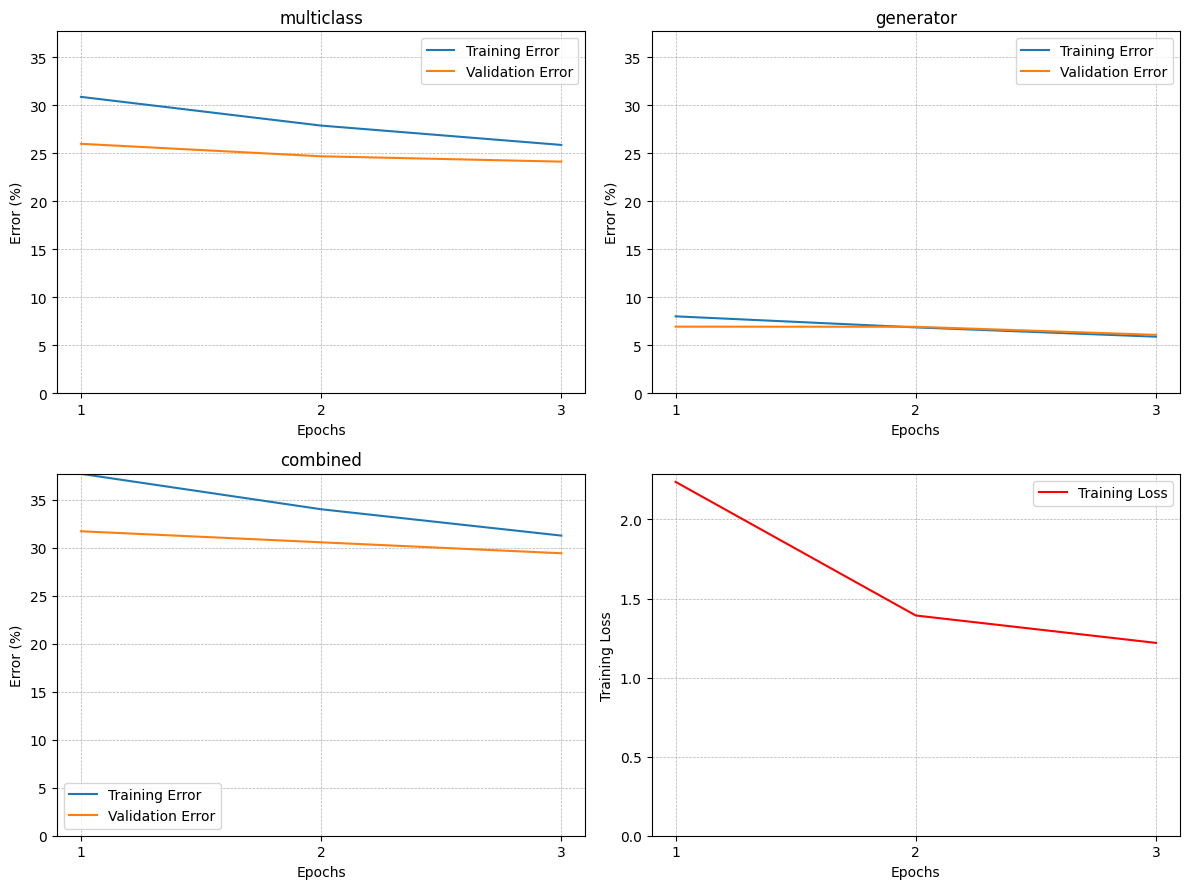

In [ ]:
model_init_function = models.multiclass_finetuning
epochs = 5
batch_size = 64
lr = 0.0001
val_batch_size = 64

val_dl = DataLoader(validation_ds, batch_size=val_batch_size, num_workers=6, prefetch_factor=6, pin_memory=True)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True, prefetch_factor=6)

# Initialize the model
model = model_init_function()
model = model.to(device)
model_name = f"{model_init_function.__name__}_batch{batch_size}"
print("\n\n - " + model_name)

# Train the model
train_errors, val_errors, train_loss = functions.train_network_multioutput(model, device, lr, epochs, train_dl, val_dl)
functions.plot_training_stats_multioutput(train_errors, val_errors, train_loss)
model_name += f"_epochs{len(train_errors['generator'])}"


# Save the progress
torch.save(model.state_dict(), './weights/' + model_name + '.pth')
stats_dict = {
'train_errors': train_errors,
'val_errors': val_errors,
'train_loss': train_loss
}
with open('./stats/' + model_name + '.pkl', 'wb') as f:
    pickle.dump(stats_dict, f)